# Ch 3. DeepWalk and random forest classifier

Goal:

- Produce high-quality feature representations of nodes in an unsupervised way.
- Inspired by Word2Vec in NLP.
- But instead of words, we work with nodes.
- Use DeepWalk to generate random walks on nodes. These act like sentences.

In [29]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from gensim.models.word2vec import Word2Vec
from sklearn.manifold import TSNE

In [30]:
random.seed(0)

## 1 Graph generation demo

In [31]:
G = nx.erdos_renyi_graph(10, 0.3, seed=1, directed=False)

/home/wwheeler/.cache/pypoetry/virtualenvs/gnn-SNQNWJZ3-py3.12/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


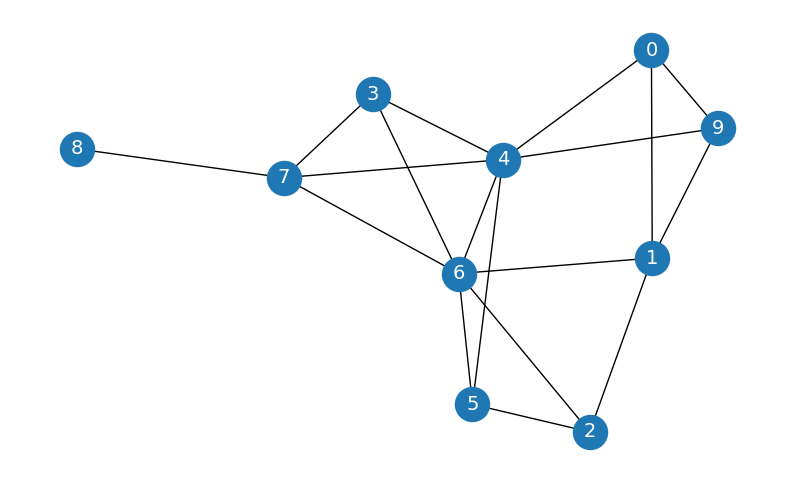

In [32]:
plt.figure(figsize=(10, 6))
plt.axis('off')
nx.draw_networkx(
    G,
    pos=nx.spring_layout(G, seed=0),
    node_size=600,
    cmap='coolwarm',
    font_size=14,
    font_color='white'
)

In [33]:
def random_walk(graph, start, length):
    walk = [str(start)]  # starting node

    for i in range(length):
        neighbors = [node for node in graph.neighbors(start)]
        next_node = np.random.choice(neighbors, 1)[0]
        walk.append(str(next_node))
        start = next_node

    return walk

In [34]:
print(random_walk(G, 0, 10))

['0', '1', '2', '6', '4', '5', '6', '1', '2', '5', '2']


## 2 DeepWalk on Zachary's Karate Club

In [35]:
zkc_graph = nx.karate_club_graph()

In [36]:
labels = []
for node in zkc_graph.nodes:
    # print(zkc_graph.nodes[node])
    label = zkc_graph.nodes[node]['club']
    labels.append(1 if label == 'Officer' else 0)

In [37]:
def plot_graph(graph, labels):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    nx.draw_networkx(
        graph,
        pos=nx.spring_layout(graph, seed=0),
        node_color=labels,
        node_size=800,
        cmap='coolwarm',
        font_size=14,
        font_color='white'
    )

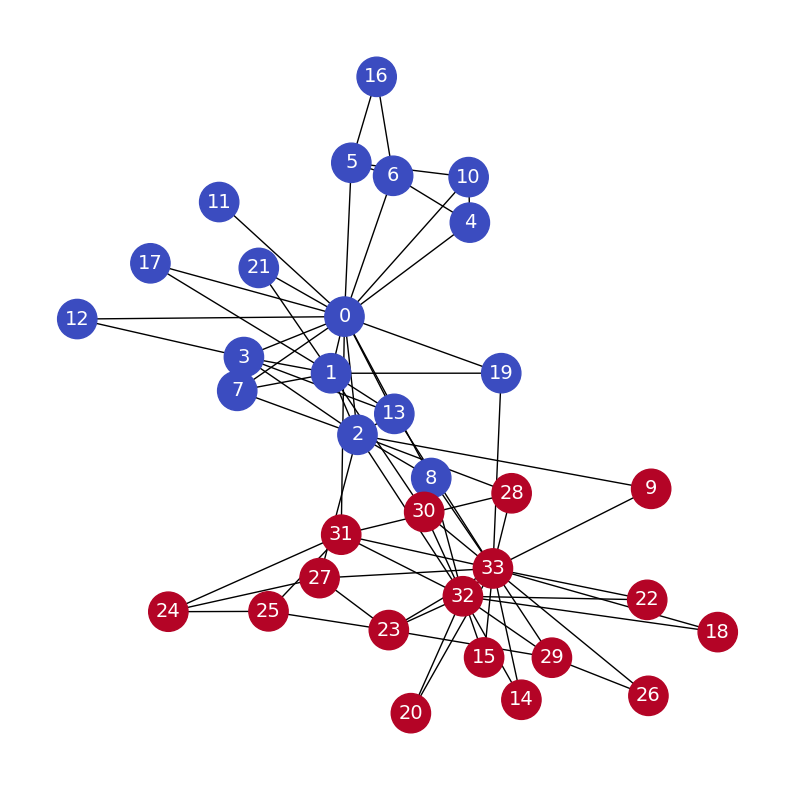

In [38]:
plot_graph(zkc_graph, labels)

### 2.1 Generate random walks on ZKC graph

This is analogous to generating sentences (random walks) of words (nodes).

In [39]:
# Generate the random walks
walks = []
for node in zkc_graph.nodes:
    for _ in range(80):
        walks.append(random_walk(zkc_graph, node, 10))

In [40]:
print(walks[0])

['0', '8', '32', '15', '33', '23', '27', '24', '31', '25', '31']


### 2.2 Train Word2Vec model on the random walk data

In [41]:
model = Word2Vec(
    walks,
    hs=1,  # hierarchical softmax
    sg=1,  # skip-gram
    vector_size=100,
    window=10,
    workers=2,
    seed=0
)

In [42]:
model.train(walks, total_examples=model.corpus_count, epochs=30, report_delay=1)

(187027, 897600)

In [43]:
# Node 4 embedding
print(model.wv['4'])

[ 2.6716011e-02 -1.4585875e-01 -3.0468386e-03  9.2564315e-02
 -3.4226397e-01  2.0114613e-01  1.3793698e-02 -2.3565906e-01
  3.0095106e-02  1.5109576e-01 -4.0328610e-03 -2.4096465e-01
 -1.2334610e-01  2.9341912e-01  1.3235991e-01 -2.2388455e-01
 -2.4822311e-02  2.2403007e-02  2.0913189e-02 -2.2508232e-01
  2.4761279e-01 -3.0208629e-02 -1.8063483e-01 -2.1586370e-02
  3.6946997e-01 -1.0698748e-01 -3.9385930e-02 -1.6858076e-01
  3.3740345e-02  2.1920621e-02  2.5570539e-01  1.3625486e-01
  4.7157276e-01 -2.5737736e-01 -1.9883218e-01  2.5314294e-02
  1.7225529e-01  5.3658091e-02  2.5790560e-04 -2.7196042e-02
  2.5696406e-02  4.1673277e-02 -1.2629247e-01 -7.2118983e-02
  3.9596781e-02 -1.8753684e-01 -2.0231648e-01 -2.3095779e-01
  2.1389540e-02 -3.9874308e-02 -1.8471749e-01 -9.8069400e-02
  2.7797699e-01  1.6902205e-01  2.9631785e-01  3.7049571e-01
  8.7363698e-02  1.9773084e-01 -3.1721103e-01  3.5186154e-03
  2.5372151e-01  2.1001813e-01  4.5390356e-01  2.6140645e-01
  1.1118053e-01 -1.94032

### 2.3 Similarity scores

In [44]:
print('Nodes that are the most similar to node 0:')
for similarity in model.wv.most_similar(positive=[0]):
    print(f'    {similarity}')

Nodes that are the most similar to node 0:
    ('32', 0.789538562297821)
    ('14', 0.7803682088851929)
    ('22', 0.7632719874382019)
    ('18', 0.7216861248016357)
    ('26', 0.7187077403068542)
    ('15', 0.7128981351852417)
    ('20', 0.7112470269203186)
    ('29', 0.6634793877601624)
    ('9', 0.569359540939331)
    ('23', 0.5397709608078003)


In [45]:
# plot_graph(zkc_graph, labels)

In [46]:
print(f"Similarity between nodes 0 and 4: {model.wv.similarity('0', '4')}")

Similarity between nodes 0 and 4: 0.645064651966095


### 2.4 T-SNE visualization

In [47]:
# Node embeddings
# Note that we cast the node indices to string since these are "words"
embeddings = np.array([model.wv.get_vector(str(i)) for i in range(len(model.wv))])

# Labels
labels = np.array(labels)

In [48]:
tsne = TSNE(
    n_components=2,
    learning_rate='auto',
    init='pca',
    random_state=0).fit_transform(embeddings)

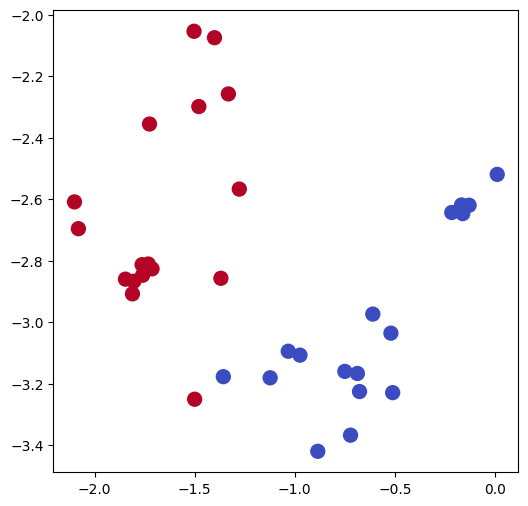

In [49]:
plt.figure(figsize=(6, 6))
plt.scatter(tsne[:, 0], tsne[:, 1], s=100, c=labels, cmap='coolwarm')
plt.show()

### 2.5 Train random forest classifier (embedding &rarr; label)

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [51]:
def get_embeddings_and_labels(model, labels, mask):
    mask_str = [str(x) for x in mask]
    return model.wv[mask_str], labels[mask]

In [52]:
train_mask = list(range(0, 29, 2))
train_embs, train_labels = get_embeddings_and_labels(model, labels, train_mask)

test_mask = list(range(1, 30, 2)) + [30, 31, 32, 33]
test_embs, test_labels = get_embeddings_and_labels(model, labels, test_mask)

In [53]:
clf = RandomForestClassifier(random_state=0)
clf.fit(train_embs, train_labels)

RandomForestClassifier(random_state=0)

In [54]:
y_pred = clf.predict(test_embs)
accuracy_score(y_pred, test_labels)

0.9473684210526315

In [55]:
y_pred

array([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1])

In [56]:
test_labels

array([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])